In [19]:
import pandas as pd

# Replace 'your_file.parquet' with the actual filename
df = pd.read_parquet('flights_processed_with_geo_no_delay.parquet')
print(df.head())
print(df.shape)

   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5            2354   
1            LAX                 PBI                   10               2   
2            SFO                 CLT                   20              18   
3            LAX                 MIA                   20              15   
4            SEA                 ANC                   25              24   

   DEPARTURE_DELAY  TAXI_OUT  SCHEDULED_TIME  DISTANCE  SCHEDULED_ARRIVAL  \
0              -11        21     

In [20]:
# Add holiday and binary weather features using existing lat/lon columns
import holidays
from meteostat import Stations, Daily
from datetime import datetime
import numpy as np

# Add US holiday column
df['date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
us_holidays = holidays.US()
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in us_holidays else 0)
df = df.drop(columns=['date'])
# Drop lat/lon columns no longer needed
df = df.drop(columns=['ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON'])

# Feature engineering
# 1. Red-eye flight (departures between 10pm-6am)
df['DEP_HOUR'] = df['SCHEDULED_DEPARTURE'] // 100
df['is_redeye'] = df['DEP_HOUR'].apply(lambda x: 1 if (x >= 22 or x < 6) else 0)

# 2. Time difference between scheduled and actual departure (in minutes)
def time_diff(sched, actual):
    try:
        sched_h, sched_m = divmod(int(sched), 100)
        actual_h, actual_m = divmod(int(actual), 100)
        sched_total = sched_h * 60 + sched_m
        actual_total = actual_h * 60 + actual_m
        # handle overnight flights
        if actual_total < sched_total:
            actual_total += 24 * 60
        return actual_total - sched_total
    except:
        return np.nan
df['DEP_TIME_DIFF'] = df.apply(lambda row: time_diff(row['SCHEDULED_DEPARTURE'], row['DEPARTURE_TIME']), axis=1)

# 3. Route feature
df['ROUTE'] = df['ORIGIN_AIRPORT'] + '_' + df['DESTINATION_AIRPORT']

# 4. Average delay per route
route_delay = df.groupby('ROUTE')['ARRIVAL_DELAY'].mean().rename('ROUTE_AVG_ARR_DELAY')
df = df.merge(route_delay, on='ROUTE', how='left')

# 5. Average delay per airline
airline_delay = df.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().rename('AIRLINE_AVG_ARR_DELAY')
df = df.merge(airline_delay, on='AIRLINE', how='left')

# 6. Average delay per flight number
flight_delay = df.groupby('FLIGHT_NUMBER')['ARRIVAL_DELAY'].mean().rename('FLIGHT_AVG_ARR_DELAY')
df = df.merge(flight_delay, on='FLIGHT_NUMBER', how='left')

# 7. Weekend feature
df['is_weekend'] = df['DAY_OF_WEEK'].apply(lambda x: 1 if x in [6, 7] else 0)

# 8. Distance buckets
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'], bins=[0, 500, 1500, 3000, np.inf], labels=['short', 'medium', 'long', 'ultra'])
df=df.drop(columns=['YEAR', 'DEP_HOUR'])  # Drop intermediate columns

In [4]:
pd.set_option("display.max_columns", None)
df.head(2)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,is_holiday,is_redeye,DEP_TIME_DIFF,ROUTE,ROUTE_AVG_ARR_DELAY,AIRLINE_AVG_ARR_DELAY,FLIGHT_AVG_ARR_DELAY,is_weekend,DISTANCE_BUCKET
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354,-11,21,205,1448,430,-22,1,1,1429,ANC_SEA,-2.530718,-0.791409,5.248766,0,medium
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2,-8,12,280,2330,750,-9,1,1,1432,LAX_PBI,10.051948,3.935214,7.615481,0,long


In [21]:
# Print null count for each column in the DataFrame
print('Null count for each column:')
print(df.isnull().sum())

Null count for each column:
MONTH                    0
DAY                      0
DAY_OF_WEEK              0
AIRLINE                  0
FLIGHT_NUMBER            0
TAIL_NUMBER              0
ORIGIN_AIRPORT           0
DESTINATION_AIRPORT      0
SCHEDULED_DEPARTURE      0
DEPARTURE_TIME           0
DEPARTURE_DELAY          0
TAXI_OUT                 0
SCHEDULED_TIME           0
DISTANCE                 0
SCHEDULED_ARRIVAL        0
ARRIVAL_DELAY            0
is_holiday               0
is_redeye                0
DEP_TIME_DIFF            0
ROUTE                    0
ROUTE_AVG_ARR_DELAY      0
AIRLINE_AVG_ARR_DELAY    0
FLIGHT_AVG_ARR_DELAY     0
is_weekend               0
DISTANCE_BUCKET          0
dtype: int64


In [22]:
# Save the DataFrame to a new parquet file
df.to_parquet('flights_processed_with_extra_features.parquet', index=False)
print('DataFrame saved to flights_processed_with_extra_features.parquet')

DataFrame saved to flights_processed_with_extra_features.parquet


In [7]:
# Perform PCA on the engineered DataFrame
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Select features for PCA (exclude target and identifiers)
exclude_cols = ['ARRIVAL_DELAY', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ROUTE', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
features = [col for col in df.columns if col not in exclude_cols]

# Encode categorical columns
cat_cols = df[features].select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Standardize features
X = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA(n_components=13)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_scaled)

print('Explained variance ratio:', pca.explained_variance_ratio_)
print('PCA shape:', X_pca.shape)

# Print cumulative explained variance for different numbers of components
cum_var = pca.explained_variance_ratio_.cumsum()
for n in range(8, len(cum_var)+1):
    print(f'Cumulative explained variance for first {n} components: {cum_var[n-1]*100:.2f}%')

Explained variance ratio: [0.1619314  0.15343524 0.09992434 0.08188806 0.0661722  0.06015559
 0.05749902 0.05498873 0.05406074 0.05244828 0.04499411 0.03625429
 0.03278705]
PCA shape: (5231130, 13)
Cumulative explained variance for first 8 components: 73.60%
Cumulative explained variance for first 9 components: 79.01%
Cumulative explained variance for first 10 components: 84.25%
Cumulative explained variance for first 11 components: 88.75%
Cumulative explained variance for first 12 components: 92.38%
Cumulative explained variance for first 13 components: 95.65%


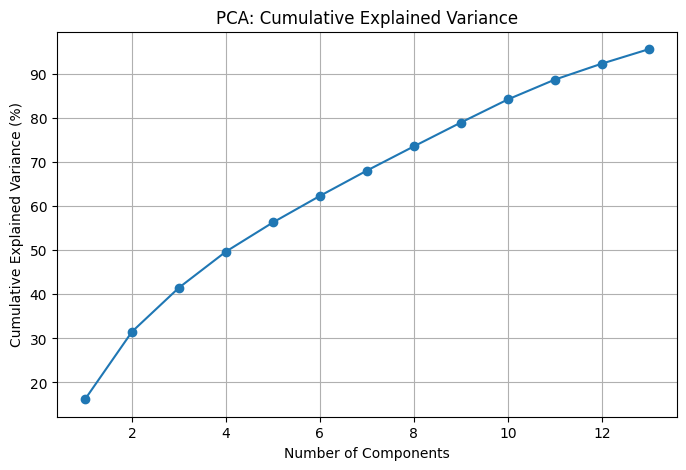

In [8]:
# ...existing code...
import matplotlib.pyplot as plt
import numpy as np

# Calculate cumulative explained variance
cum_var = pca.explained_variance_ratio_.cumsum()
n_components = np.arange(1, len(cum_var) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_components, cum_var * 100, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [11]:
# ...existing code...
import pandas as pd

# Convert PCA output to DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Optionally, add back the index or identifiers if needed
# pca_df['FLIGHT_NUMBER'] = df['FLIGHT_NUMBER'].values

# Save to parquet
# pca_df.to_parquet('flights_pca_output.parquet', index=False)
# print('PCA output saved to flights_pca_output.parquet')

In [12]:
pca_df.shape

(5231130, 13)

In [13]:
# ...existing code...
# Show how original features contribute to each principal component
pca_components_df = pd.DataFrame(
    pca.components_,
    columns=features,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
print(pca_components_df)
# ...existing code...

         MONTH       DAY  DAY_OF_WEEK  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
PC1   0.015070  0.003010     0.019594            -0.130103       -0.135930   
PC2  -0.007833 -0.001878     0.011321             0.538392        0.546612   
PC3  -0.012665  0.021866     0.698732             0.007279        0.003546   
PC4  -0.052294  0.003727     0.031499            -0.192093       -0.163411   
PC5  -0.064500  0.009199     0.026188            -0.087953       -0.045364   
PC6   0.306646  0.088151    -0.005613             0.146082        0.112389   
PC7  -0.054104  0.741038    -0.063824             0.006355        0.002251   
PC8   0.933050  0.119599     0.009876            -0.052849       -0.037682   
PC9   0.055690 -0.365267     0.026572             0.063903        0.045957   
PC10 -0.142175  0.542806     0.065278             0.027818        0.021706   
PC11  0.032881 -0.007158    -0.002189            -0.064925       -0.064916   
PC12  0.009994  0.000522    -0.003003            -0.002804      